### Setup

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
# To generate GIFs
!pip install gitpython
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 163kB 16.0MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 


In [ ]:
# !pip install glob3
# import glob3

In [ ]:
!pip install matplotlib
!pip install numpy

import imageio
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from IPython import display
import time
import os

In [ ]:
import tqdm.notebook as tq
from os import listdir
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.image as mpimg

In [ ]:
#--Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

from PIL import Image
print(Image.__file__)

import Image
print(Image.__file__)

import PIL

!pip install sklearn
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/PIL/Image.py
/usr/local/lib/python3.6/dist-packages/PIL/Image.py


### Load and prepare the dataset

In [ ]:
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
from tensorflow.keras.models import Sequential

In [ ]:
#--some helpful stuff for loading images
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
#--loading images
#trainfolder='/content/drive/MyDrive/20F/ENGS108_Final_Project/Data_Sets/maps/maps/trainB/'
trainfolder='/content/drive/MyDrive/20F/ENGS108_Final_Project/Data_Sets/roads_only/'

size=(128,128)

trainimages=list()
for filename in listdir(trainfolder):
      # load and resize the image
      pixels = load_img(trainfolder + filename, target_size=size)
      # convert to numpy array
      pixels = img_to_array(pixels)
      # Normalize the images to [-1, 1]
      #pixels=(pixels- 127.5) / 127.5
      # store
      trainimages.append(pixels)

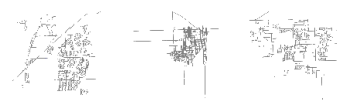

In [ ]:
from matplotlib import pyplot
#--plot images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainimages[i].astype('uint8'))

In [ ]:
BUFFER_SIZE = 10000 #60000
BATCH_SIZE = 64 # changed from 256 for memory purposes

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(trainimages).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
len(train_dataset)

5

len(train_dataset)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
# output image: 16x16 => 64x64 => 128x128 (final output image is 128x128x3)
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    #model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)   # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))  #128
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))  #128
    assert model.output_shape == (None, 64, 64, 64)   #128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))  #128
    assert model.output_shape == (None, 128, 128, 64)   #128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), padding='same', use_bias=False, activation='tanh')) #originally also had strides
    assert model.output_shape == (None, 128, 128, 3)

    return model

Use the (as yet untrained) generator to create an image.

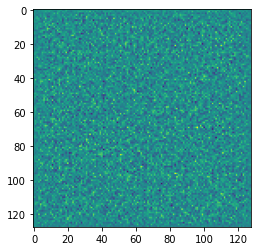

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00032957]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss: if we choose to use binary cross entropy; currently using mse
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    #real_loss = tf.keras.losses.mse(tf.ones_like(real_output), real_output)
    #fake_loss = tf.keras.losses.mse(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  ##if using binary crossentropy
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  ##if using binary crossentropy
    total_loss = real_loss + fake_loss
    return total_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    #return tf.keras.losses.mse(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)  ## if using binary crossentropy


The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 5000  #10000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce an image for each epoch to showcase progress
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
     
    fig=plt.figure(figsize=(10, 10))
    plt.imshow( np.reshape((0.5 * generator.predict(np.random.normal(0,1,(1,100))) + 0.5), (128, 128, 3)))
    plt.axis('off')

    plt.show()
    
#   predictions = model(test_input, training=False)

#   fig = plt.figure(figsize=(4,4))

#   for i in range(predictions.shape[0]):
#       plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#       plt.axis('off')

#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#   plt.show()

## Train the model


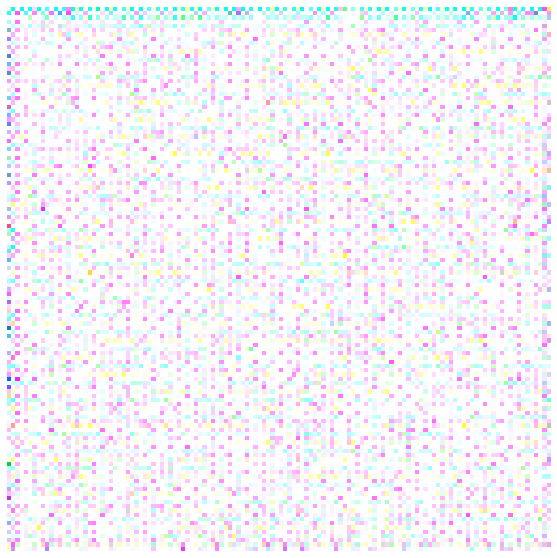

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)